# ECE 225A Project: Regime-Aware Risk in the S&P 500

**Authors:** [Your Name(s)]  
**Course:** ECE 225A – Probability and Statistics for Data Science  
**Date:** December 2025

---

**Abstract:** This notebook explores whether explicitly modeling volatility regimes improves risk assessment and portfolio allocation for the S&P 500 during H1 2025. We combine GARCH volatility modeling with Markov-switching regime detection, compute sector-level tail risk (VaR/ES), and compare three portfolio strategies under different market conditions.



## 1. Data Description

This section describes the dataset used in our analysis.

- **Source:** Kaggle dataset "S&P 500 stocks trade data for first 6 months of 2025"
- **Contents:** Daily open, close, and volume for 503 S&P 500 constituents
- **Time period:** January 2 – June 30, 2025 (122 trading days)
- **Structure:** Wide format with columns like `02-01-2025_opening`, `02-01-2025_closing`, `02-01-2025_volume`
- **Identifiers:** `company_name` and `ticker` for each stock
- **Supplementary data:** Sector mappings from GitHub's `datasets/s-and-p-500-companies` (loaded dynamically)



### Research Question

**Can regime-aware modeling improve risk assessment and portfolio allocation?**

We investigate whether explicitly identifying high- and low-volatility regimes (via Markov switching) leads to better understanding of tail risk and portfolio performance compared to unconditional approaches.



## 2. Preprocessing and Log Returns

In this section, we load the raw CSV data, reshape it from wide to long format, and compute daily log returns for each stock. Log returns are preferred because they are additive over time and more closely approximate a normal distribution than simple returns.

The data loader first checks for the Kaggle input path; if unavailable (e.g., running locally), it falls back to `sp500_2025_h1.csv` in the repository root.


- Source: Kaggle dataset “S&P 500 stocks trade data for first 6 months of 2025” (daily open/close/volume per constituent); fallback to local `sp500_2025_h1.csv` in repo root if not running on Kaggle.
- Structure: 503 tickers × daily columns (e.g., `02-01-2025_opening`, `02-01-2025_closing`, `02-01-2025_volume`) plus `company_name` and `ticker` identifiers.
- Time span: 2025-01-03 to 2025-06-30 (121 trading days after differencing).
- External reference for sectors (if reachable): GitHub `datasets/s-and-p-500-companies` constituents file to map tickers → sectors.



### Reshaping and Return Calculation

The code below melts the wide-format data into a tidy panel (one row per ticker-date), then computes log returns as $r_t = \ln(P_t / P_{t-1})$.



In [20]:
# Install required packages if needed (comment out if already installed)
%pip install -q numpy pandas matplotlib statsmodels scikit-learn scipy arch



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
# Standard library imports
import os
import random
from pathlib import Path

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Statistical modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.covariance import LedoitWolf
from scipy.stats import norm
from arch import arch_model

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")

# Reproducibility: set fixed random seeds
random.seed(0)
np.random.seed(0)

# Robust data loader: prefer Kaggle input path, otherwise local repo CSV
kaggle_path = Path("/kaggle/input/s-and-p-500-stocks-trade-data-for-first-6-month-2025/sp500_2025_h1.csv")
local_path = Path("sp500_2025_h1.csv")

if kaggle_path.exists():
    data_path = kaggle_path
elif local_path.exists():
    data_path = local_path
else:
    raise FileNotFoundError("Could not find sp500_2025_h1.csv in Kaggle input or repo root.")

df = pd.read_csv(data_path)

print("Shape:", df.shape)
print(df.head())

Shape: (503, 368)
     company_name ticker  02-01-2025_opening  02-01-2025_closing  \
0          Nvidia   NVDA             136.000             138.310   
1       Microsoft   MSFT             425.530             418.580   
2      Apple Inc.   AAPL             248.657             243.582   
3          Amazon   AMZN             222.030             220.220   
4  Meta Platforms   META             589.720             599.240   

   02-01-2025_volume  03-01-2025_opening  03-01-2025_closing  \
0          198247166             140.010             144.470   
1           16896469             421.080             423.350   
2           55802016             243.093             243.093   
3           33956579             222.505             224.190   
4           12682269             604.760             604.630   

   03-01-2025_volume  06-01-2025_opening  06-01-2025_closing  ...  \
0          229322478             148.590             149.430  ...   
1           16662943             428.000          

The following code performs the wide-to-long transformation and computes log returns:

In [22]:
id_cols = ["company_name", "ticker"]
all_cols = df.columns.tolist()

# Identify opening/closing/volume columns (wide → long prep)
open_cols = [c for c in all_cols if c.endswith("_opening")]
close_cols = [c for c in all_cols if c.endswith("_closing")]
volume_cols = [c for c in all_cols if c.endswith("_volume")]

print(f"# opening columns: {len(open_cols)}")
print(f"# closing columns: {len(close_cols)}")
print(f"# volume columns:  {len(volume_cols)}")

# Melt daily close prices to long format
df_close = df.melt(
    id_vars=id_cols,
    value_vars=close_cols,
    var_name="date_col",
    value_name="close"
)
df_close["date_str"] = df_close["date_col"].str.replace("_closing", "", regex=False)
df_close = df_close.drop(columns=["date_col"])

# Melt daily open prices to long format
df_open = df.melt(
    id_vars=id_cols,
    value_vars=open_cols,
    var_name="date_col",
    value_name="open"
)
df_open["date_str"] = df_open["date_col"].str.replace("_opening", "", regex=False)
df_open = df_open.drop(columns=["date_col"])

# Melt volumes if present
if len(volume_cols) > 0:
    df_vol = df.melt(
        id_vars=id_cols,
        value_vars=volume_cols,
        var_name="date_col",
        value_name="volume"
    )
    df_vol["date_str"] = df_vol["date_col"].str.replace("_volume", "", regex=False)
    df_vol = df_vol.drop(columns=["date_col"])
else:
    df_vol = None

# Merge open/close/volume and compute log returns per ticker
df_long = df_close.merge(
    df_open,
    on = id_cols + ["date_str"],
    how = "left",
    suffixes = ("_close", "_open")
)
if df_vol is not None:
    df_long = df_long.merge(
        df_vol[id_cols + ["date_str", "volume"]],
        on = id_cols + ["date_str"],
        how = "left"
    )

df_long["date"] = pd.to_datetime(df_long["date_str"], format = "%d-%m-%Y")
df_long = df_long.sort_values(["ticker", "date"])

df_long["log_return"] = (
    df_long.groupby("ticker")["close"].transform(lambda x: np.log(x).diff())
)

# Drop the first observation per ticker (diff = NaN) and keep clean panel
df_long = df_long.dropna(subset = ["log_return"])

print(df_long.head())
print("Unique tickers:", df_long["ticker"].nunique())
print("Date range:", df_long["date"].min(), "→", df_long["date"].max())

# opening columns: 122
# closing columns: 122
# volume columns:  122
              company_name ticker   close    date_str     open   volume  \
753   Agilent Technologies      A  135.69  03-01-2025  133.525  1246919   
1256  Agilent Technologies      A  136.43  06-01-2025  135.340  1047034   
1759  Agilent Technologies      A  137.41  07-01-2025  135.980  1056693   
2262  Agilent Technologies      A  137.00  08-01-2025  137.220  1684573   
2765  Agilent Technologies      A  137.47  10-01-2025  135.195  1369875   

           date  log_return  
753  2025-01-03    0.016796  
1256 2025-01-06    0.005439  
1759 2025-01-07    0.007157  
2262 2025-01-08   -0.002988  
2765 2025-01-10    0.003425  
Unique tickers: 503
Date range: 2025-01-03 00:00:00 → 2025-06-30 00:00:00


## 3. Time-Series Diagnostics (Autocorrelation, Heavy Tails, Conditional Heteroskedasticity)

Before modeling, we examine the statistical properties of returns to justify our modeling choices. We construct an equal-weight market index proxy and inspect:

1. **Distribution shape** – Histogram and QQ-plot to check for departures from normality (fat tails)
2. **Autocorrelation of returns** – ACF to detect any predictable patterns in returns
3. **Autocorrelation of squared returns** – ACF to detect volatility clustering (conditional heteroskedasticity)

Sample ticker: AAPL


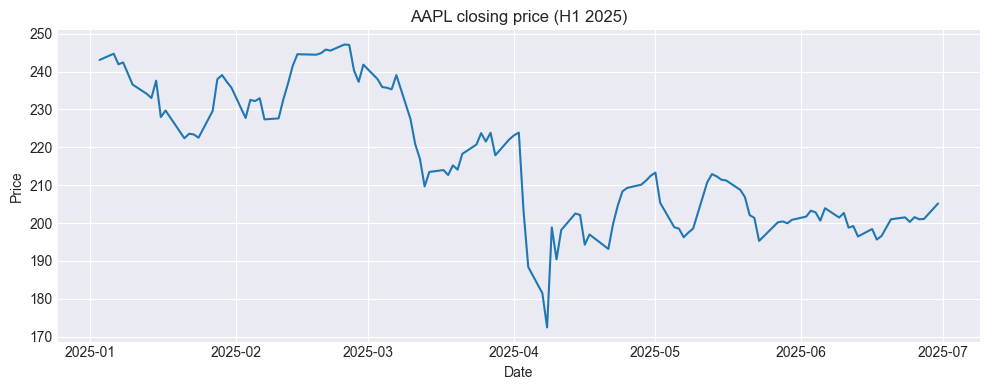

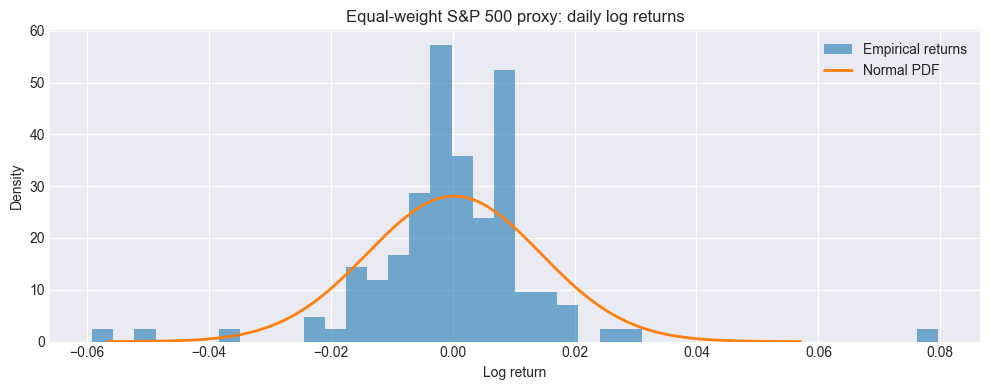

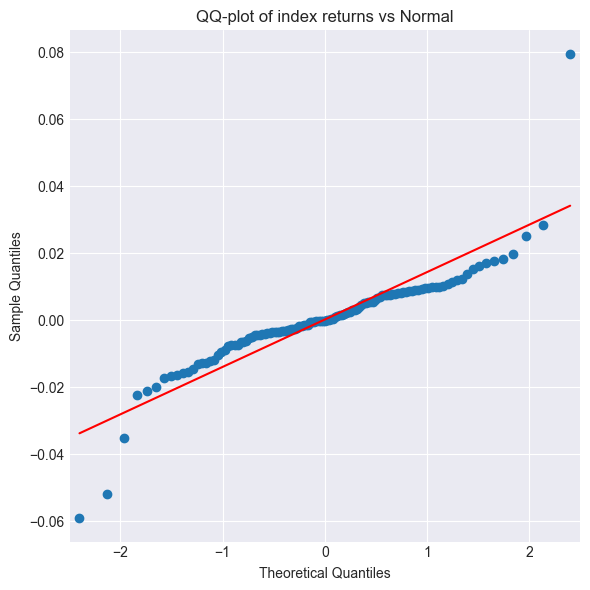

<Figure size 1000x400 with 0 Axes>

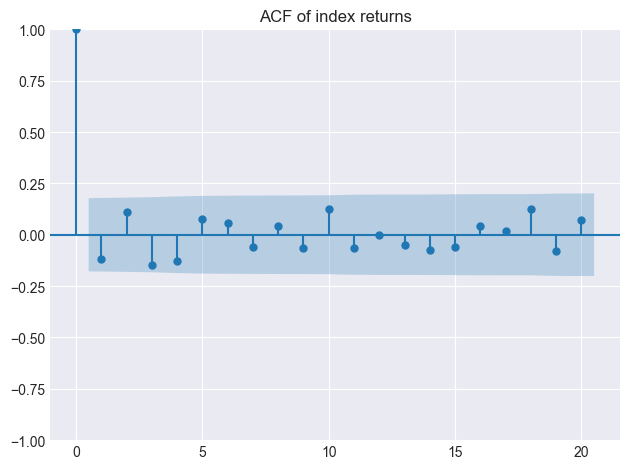

<Figure size 1000x400 with 0 Axes>

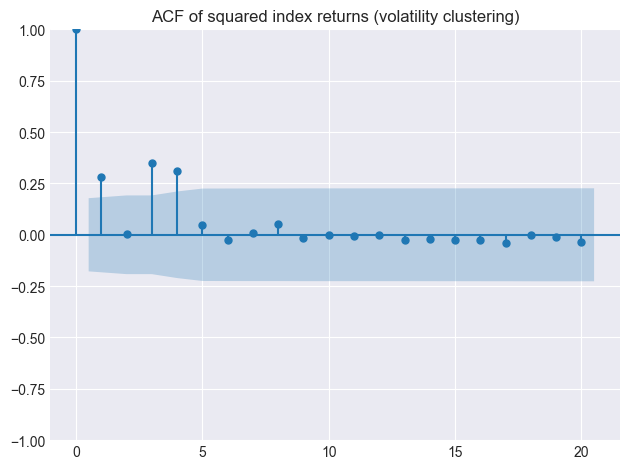

In [ ]:
# Equal-weight index proxy across all tickers (simple market proxy)
index_returns = (
    df_long.groupby("date")["log_return"]
    .mean()
    .sort_index()
)
index_returns.name = "sp500_eqw"

# Inspect one liquid name for intuition on raw price path
tickers = df_long["ticker"].unique()
sample_ticker = "AAPL" if "AAPL" in tickers else tickers[0]
print("Sample ticker:", sample_ticker)

sample_df = (
    df_long[df_long["ticker"] == sample_ticker]
    .sort_values("date")
    .set_index("date")
)

# FIGURE 1: Sample stock price path
# Notice: The price shows typical equity behavior with trends and volatility clusters
plt.figure(figsize=(10, 4))
plt.plot(sample_df.index, sample_df["close"], color="steelblue", linewidth=1.5)
plt.title(f"{sample_ticker} Daily Closing Price (H1 2025)", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

r = index_returns.dropna()
mu = r.mean()
sigma = r.std()

# FIGURE 2: Return distribution vs Normal
# Notice: The empirical distribution has fatter tails than the Normal (excess kurtosis)
plt.figure(figsize=(10, 4))
plt.hist(r, bins=40, density=True, alpha=0.6, color="steelblue", edgecolor="white", label="Empirical returns")
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 200)
plt.plot(x, norm.pdf(x, mu, sigma), lw=2, color="crimson", label="Normal PDF")
plt.title("Equal-Weight S&P 500 Proxy: Daily Log Return Distribution", fontsize=12, fontweight="bold")
plt.xlabel("Log Return")
plt.ylabel("Probability Density")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 3: QQ-plot
# Notice: Points deviate from the line in both tails, confirming fat tails (leptokurtosis)
fig = sm.qqplot(r, line="s")
fig.set_size_inches(6, 6)
ax = fig.axes[0]
ax.set_title("QQ-Plot: Index Returns vs. Normal Distribution", fontsize=12, fontweight="bold")
ax.set_xlabel("Theoretical Quantiles (Normal)")
ax.set_ylabel("Sample Quantiles (Returns)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 4: ACF of returns
# Notice: Returns show little autocorrelation (market efficiency), mostly within confidence bands
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(r, lags=20, ax=ax)
ax.set_title("Autocorrelation Function (ACF) of Daily Returns", fontsize=12, fontweight="bold")
ax.set_xlabel("Lag (Days)")
ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# FIGURE 5: ACF of squared returns
# Notice: Squared returns show significant autocorrelation — evidence of volatility clustering
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(r ** 2, lags=20, ax=ax)
ax.set_title("ACF of Squared Returns (Volatility Clustering)", fontsize=12, fontweight="bold")
ax.set_xlabel("Lag (Days)")
ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

## 4. Volatility Modeling (GARCH)

Given the evidence of volatility clustering from Section 3, we fit a **GARCH(1,1) model** with Student-t innovations to capture time-varying conditional volatility. The GARCH(1,1) specification is:

$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

where $\alpha + \beta < 1$ ensures stationarity. We use Student-t innovations to accommodate the fat tails observed in the QQ-plot.

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    sp500_eqw   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -179.855
Distribution:      Standardized Student's t   AIC:                           369.711
Method:                  Maximum Likelihood   BIC:                           383.690
                                              No. Observations:                  121
Date:                      Sat, Dec 06 2025   Df Residuals:                      120
Time:                              00:49:34   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

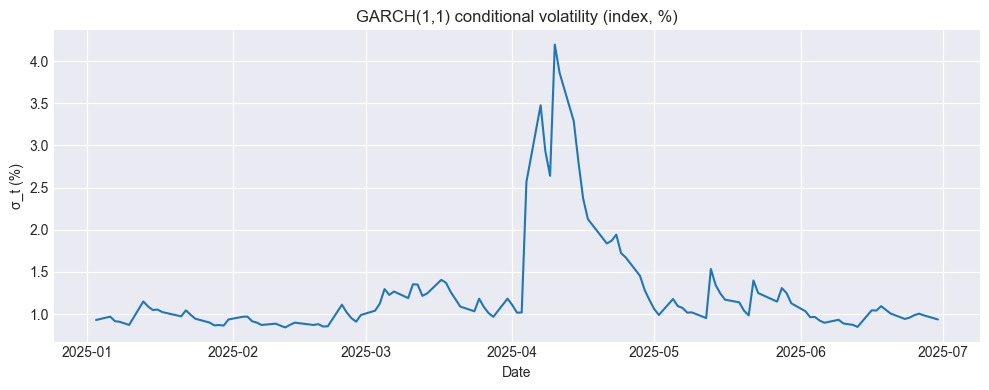

In [ ]:
# Scale to percentage points to match typical GARCH parameter magnitudes
index_returns_pct = r * 100

# Student-t GARCH(1,1) to capture fat tails and volatility clustering
am = arch_model(index_returns_pct, vol="Garch", p=1, q=1, dist="t")
res_garch = am.fit(update_freq=5, disp="off")

print(res_garch.summary())

cond_vol = res_garch.conditional_volatility

# FIGURE 6: GARCH conditional volatility over time
# Notice: Volatility spikes during turbulent periods and mean-reverts during calm periods
plt.figure(figsize=(10, 4))
plt.plot(r.index, cond_vol, color="darkorange", linewidth=1.5)
plt.fill_between(r.index, 0, cond_vol, alpha=0.3, color="orange")
plt.title("GARCH(1,1) Conditional Volatility Over Time", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Conditional Volatility σₜ (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Regime Switching (Markov Switching Model)

We fit a **two-state Markov-switching model** to identify distinct volatility regimes:

- **Regime 0 (Low volatility):** Calm market conditions with smaller daily moves
- **Regime 1 (High volatility):** Turbulent periods with larger swings

The model estimates regime-specific means and variances, plus transition probabilities $P(S_t = j | S_{t-1} = i)$. We extract smoothed regime probabilities to classify each day and visualize how regimes align with market movements.

                        Markov Switching Model Results                        
Dep. Variable:                      y   No. Observations:                  121
Model:               MarkovRegression   Log Likelihood                 377.421
Date:                Sat, 06 Dec 2025   AIC                           -742.841
Time:                        00:49:34   BIC                           -726.067
Sample:                             0   HQIC                          -736.028
                                - 121                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.100      0.272      -0.001       0.003
sigma2      8.449e-05   1.18e-05      7.144      0.0

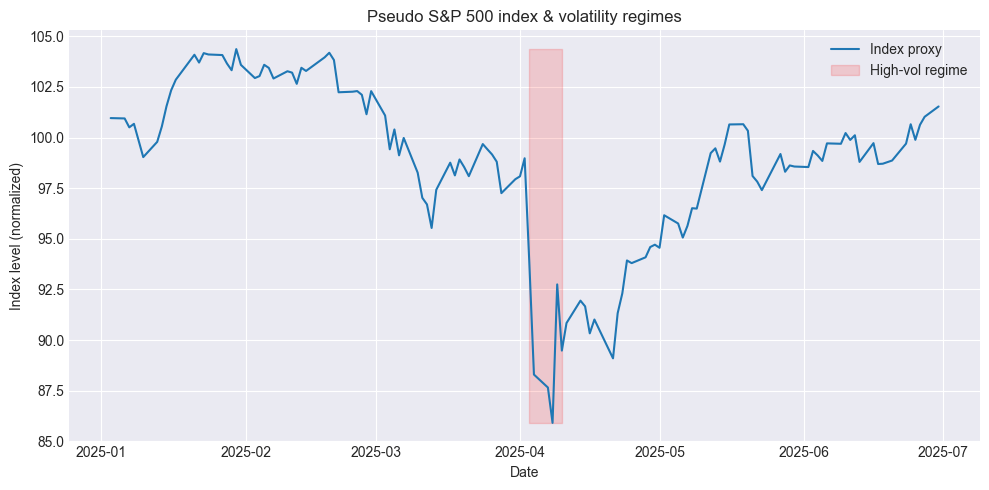

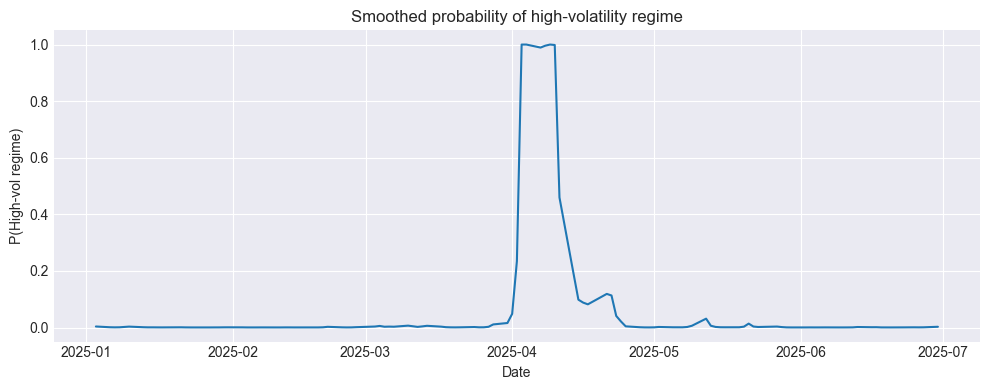

In [ ]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Two-state Markov switching on index returns (switching variance allowed)
y = r.values
mod_ms = MarkovRegression(
    y,
    k_regimes = 2,
    trend = "c",
    switching_variance = True
)
res_ms = mod_ms.fit(em_iter = 50, search_reps = 20)
print(res_ms.summary())

# Smoothed probability of the high-volatility regime
# FIX: handle both DataFrame and ndarray returns from statsmodels
prob_raw = res_ms.smoothed_marginal_probabilities
if hasattr(prob_raw, "values"):
    # DataFrame case: extract column 1
    prob_high = pd.Series(prob_raw[1].values, index=r.index, name="prob_high")
else:
    # ndarray case: column 1 is second column
    prob_high = pd.Series(prob_raw[:, 1], index=r.index, name="prob_high")
regime_series = (prob_high > 0.5).astype(int)
regime_series.name = "high_vol_regime"

index_level = (1 + r).cumprod() * 100

# FIGURE 7: Index level with regime overlay
# Notice: Red shading marks high-volatility periods — often coincide with market drawdowns
plt.figure(figsize=(10, 5))
plt.plot(index_level.index, index_level.values, label="Index proxy", color="steelblue", linewidth=1.5)
high_mask = regime_series == 1
plt.fill_between(
    index_level.index,
    index_level.min(),
    index_level.max(),
    where=high_mask,
    color="red",
    alpha=0.15,
    label="High-vol regime"
)
plt.title("S&P 500 Index Proxy with Volatility Regime Overlay", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Index Level (Base = 100)")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 8: Smoothed regime probabilities
# Notice: Probability near 1 indicates high-vol regime; near 0 indicates low-vol regime
plt.figure(figsize=(10, 4))
plt.plot(prob_high.index, prob_high.values, color="crimson", linewidth=1.5)
plt.fill_between(prob_high.index, 0, prob_high.values, alpha=0.3, color="red")
plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Classification threshold")
plt.title("Smoothed Probability of High-Volatility Regime", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("P(High-Vol Regime)")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Sector Risk: Value-at-Risk and Expected Shortfall

We assess tail risk at the sector level using two standard risk measures:

- **Value-at-Risk (VaR):** The $\alpha$-quantile loss; at 95% confidence, the loss exceeded only 5% of the time
- **Expected Shortfall (ES):** The average loss conditional on exceeding VaR (also called CVaR)

We map tickers to GICS sectors using an external reference file, compute equal-weight sector returns, estimate historical VaR/ES, and backtest by checking breach ratios.

Loaded sector info from GitHub (cols: symbol, gics sector); 484 rows mapped to 'Unknown'.
Sector returns shape: (121, 12)
Sectors: ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Unknown', 'Utilities']
Sector VaR (95%):
Unknown                  -0.065108
Information Technology   -0.032883
Energy                   -0.029714
Consumer Discretionary   -0.024959
Financials               -0.024437
Real Estate              -0.022470
Communication Services   -0.022044
Health Care              -0.020824
Industrials              -0.020579
Utilities                -0.019883
Materials                -0.019027
Consumer Staples         -0.019010
dtype: float64

Sector ES (95%):
Unknown                  -0.094387
Energy                   -0.057422
Information Technology   -0.049587
Financials               -0.039918
Materials                -0.037403
Consumer Discretio

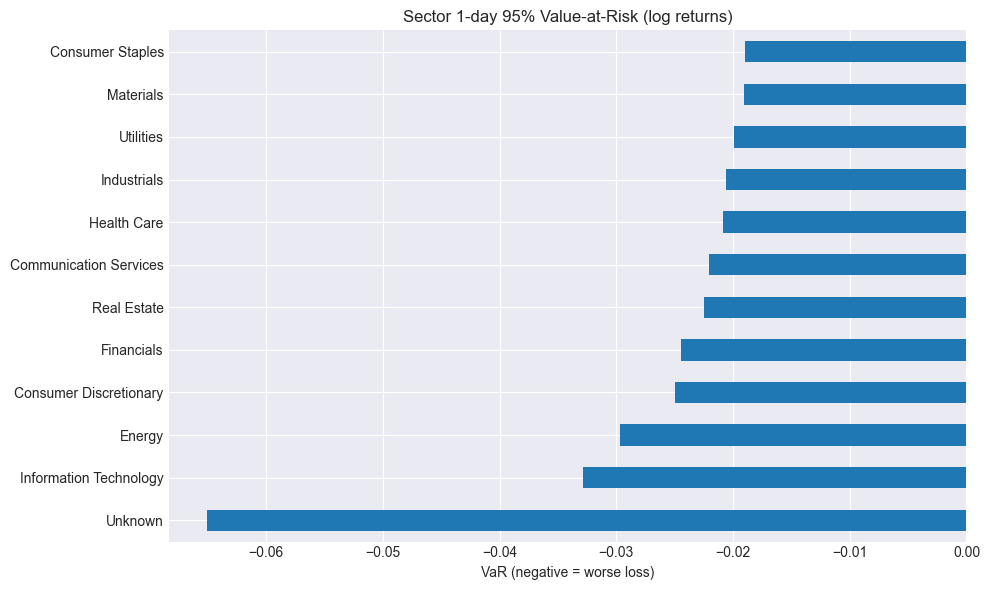

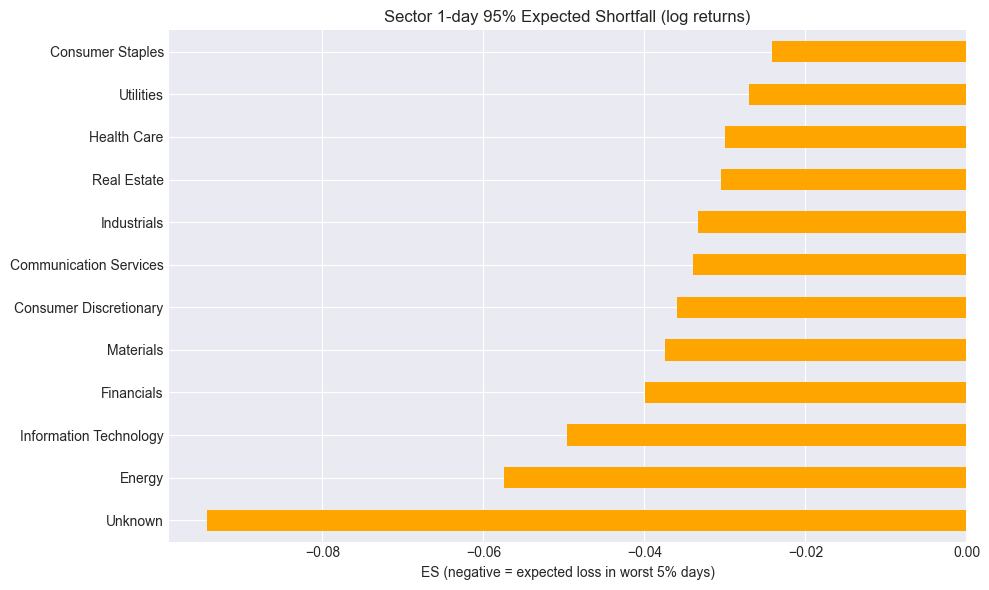


Approximate VaR breach ratios (should be ~5% for a perfect 95% VaR):
sector
Consumer Discretionary    0.049587
Materials                 0.049587
Real Estate               0.049587
Communication Services    0.057851
Consumer Staples          0.057851
Energy                    0.057851
Financials                0.057851
Health Care               0.057851
Industrials               0.057851
Information Technology    0.057851
Unknown                   0.057851
Utilities                 0.057851
dtype: float64


In [ ]:
df_long_sect = df_long.copy()

# Map tickers to sectors (robust to alternative column names); fall back to Unknown
# FIX: expanded column detection to handle various GitHub file formats
try:
    sector_url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
    cons = pd.read_csv(sector_url)
    # Normalize column names (lowercase, strip whitespace)
    cons.columns = cons.columns.str.strip().str.lower()
    # Detect ticker column
    ticker_col = None
    for c in ["symbol", "ticker"]:
        if c in cons.columns:
            ticker_col = c
            break
    # Detect sector column (try multiple common names)
    sector_col = None
    for c in ["sector", "gics sector", "gics_sector", "industry"]:
        if c in cons.columns:
            sector_col = c
            break
    if ticker_col and sector_col:
        cons = cons.rename(columns = {ticker_col: "ticker", sector_col: "sector"})
        cons["ticker"] = cons["ticker"].str.upper()
        sector_map = cons.set_index("ticker")["sector"]
        df_long_sect["sector"] = df_long_sect["ticker"].str.upper().map(sector_map)
        missing = df_long_sect["sector"].isna().sum()
        df_long_sect["sector"] = df_long_sect["sector"].fillna("Unknown")
        msg = f"Loaded sector info from GitHub (cols: {ticker_col}, {sector_col}); {missing} rows mapped to 'Unknown'."
        print(msg)
    else:
        raise ValueError(f"Could not find ticker/sector columns. Available: {list(cons.columns)}")
except Exception as e:
    print("Could not load sector info, using 'Unknown' for all. Error:", e)
    df_long_sect["sector"] = "Unknown"

df_long_sect = df_long_sect.dropna(subset = ["log_return"])

sector_returns = (
    df_long_sect.groupby(["date", "sector"])["log_return"]
    .mean()
    .unstack("sector")
    .sort_index()
)

print("Sector returns shape:", sector_returns.shape)
print("Sectors:", sector_returns.columns.tolist())

alpha = 0.95

def compute_var_es(series, alpha = 0.95):
    series = series.dropna()
    q = series.quantile(1 - alpha)
    es = series[series <= q].mean()
    return q, es

var_sector = {}
es_sector = {}

for sector in sector_returns.columns:
    q, es = compute_var_es(sector_returns[sector], alpha = alpha)
    var_sector[sector] = q
    es_sector[sector] = es

var_sector = pd.Series(var_sector)
es_sector = pd.Series(es_sector)

print("Sector VaR (95%):")
print(var_sector.sort_values())
print("\nSector ES (95%):")
print(es_sector.sort_values())

# FIGURE 9: Sector Value-at-Risk
# Notice: More negative VaR = higher tail risk; Info Tech and Energy have the largest losses
plt.figure(figsize=(10, 6))
colors = ["#d62728" if v < var_sector.median() else "#2ca02c" for v in var_sector.sort_values()]
var_sector.sort_values().plot(kind="barh", color=colors, edgecolor="black", linewidth=0.5)
plt.title("Sector 1-Day 95% Value-at-Risk (VaR)", fontsize=12, fontweight="bold")
plt.xlabel("VaR (Log Return) — More Negative = Higher Risk")
plt.ylabel("GICS Sector")
plt.axvline(x=0, color="black", linewidth=0.8)
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# FIGURE 10: Sector Expected Shortfall
# Notice: ES is always more negative than VaR — it captures average loss in the worst 5% of days
plt.figure(figsize=(10, 6))
colors = ["#d62728" if v < es_sector.median() else "#ff7f0e" for v in es_sector.sort_values()]
es_sector.sort_values().plot(kind="barh", color=colors, edgecolor="black", linewidth=0.5)
plt.title("Sector 1-Day 95% Expected Shortfall (CVaR)", fontsize=12, fontweight="bold")
plt.xlabel("ES (Log Return) — Average Loss in Worst 5% of Days")
plt.ylabel("GICS Sector")
plt.axvline(x=0, color="black", linewidth=0.8)
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# VaR backtest proxy: share of days breaching estimated 95% VaR
breach_ratios = (sector_returns.lt(var_sector)).sum() / sector_returns.notna().sum()
print("\nApproximate VaR breach ratios (should be ~5% for a perfect 95% VaR):")
print(breach_ratios.sort_values())

## 7. Portfolio Strategies and Performance

We construct and compare three portfolio strategies:

| Strategy | Description |
|----------|-------------|
| **Equal-Weight (EW)** | $w_i = 1/N$ for all assets |
| **Inverse-Volatility (IV)** | $w_i \propto 1/\sigma_i$ — tilts toward lower-volatility stocks |
| **Minimum-Variance (MV)** | $w = \Sigma^{-1} \mathbf{1} / (\mathbf{1}'\Sigma^{-1}\mathbf{1})$ — uses Ledoit-Wolf shrinkage covariance |

We evaluate annualized return, volatility, Sharpe ratio, and maximum drawdown. Finally, we split performance by volatility regime to see whether regime-aware analysis provides additional insight.

Returns matrix shape: (121, 503)
Equal-weight weights sum: 1.0
Inverse-vol weights sum: 1.0000000000000002
Min-var weights sum: 1.0

=== Portfolio: EW ===
     ann_return: 0.0569
        ann_vol: 0.2256
         sharpe: 0.2523
   max_drawdown: -0.1768

=== Portfolio: IV ===
     ann_return: 0.0703
        ann_vol: 0.1995
         sharpe: 0.3523
   max_drawdown: -0.1453

=== Portfolio: MV ===
     ann_return: 0.0438
        ann_vol: 0.1871
         sharpe: 0.2342
   max_drawdown: -0.1555


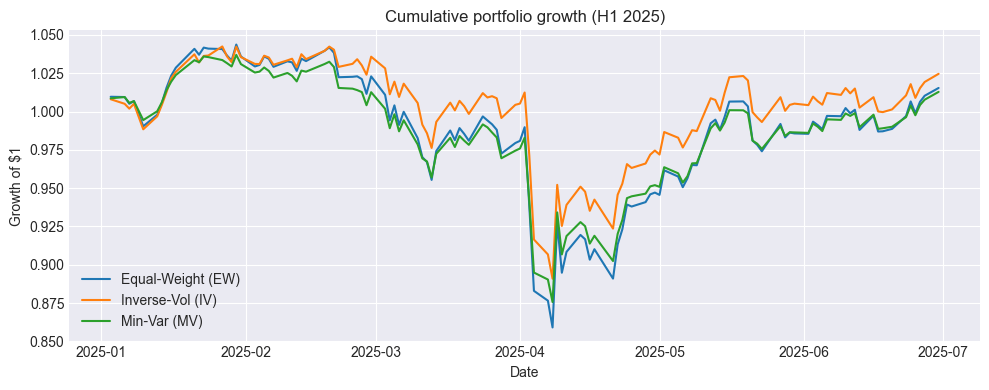

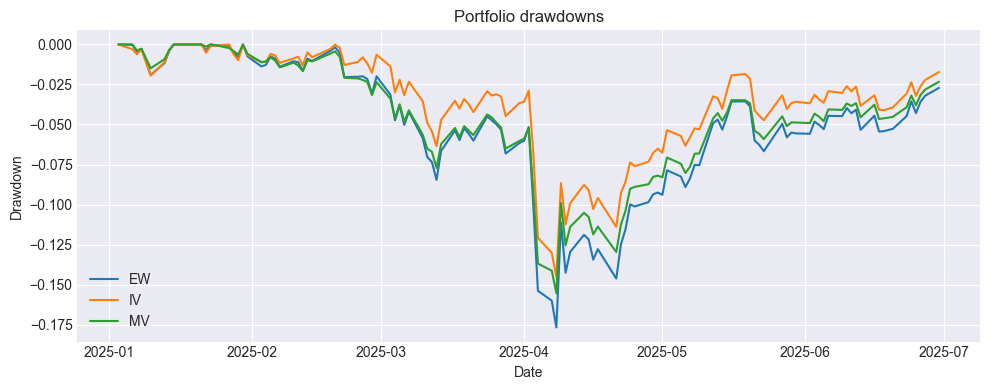


===== Low-vol regime =====
Portfolio EW: ann_return=0.2653, ann_vol=0.1480, sharpe=1.7926, max_dd=-0.0846
Portfolio IV: ann_return=0.2591, ann_vol=0.1336, sharpe=1.9389, max_dd=-0.0635
Portfolio MV: ann_return=0.2121, ann_vol=0.1222, sharpe=1.7358, max_dd=-0.0772

===== High-vol regime =====
Portfolio EW: ann_return=-3.9374, ann_vol=0.8012, sharpe=-4.9142, max_dd=-0.0845
Portfolio IV: ann_return=-3.5490, ann_vol=0.6945, sharpe=-5.1098, max_dd=-0.0827
Portfolio MV: ann_return=-3.1809, ann_vol=0.6690, sharpe=-4.7544, max_dd=-0.0700


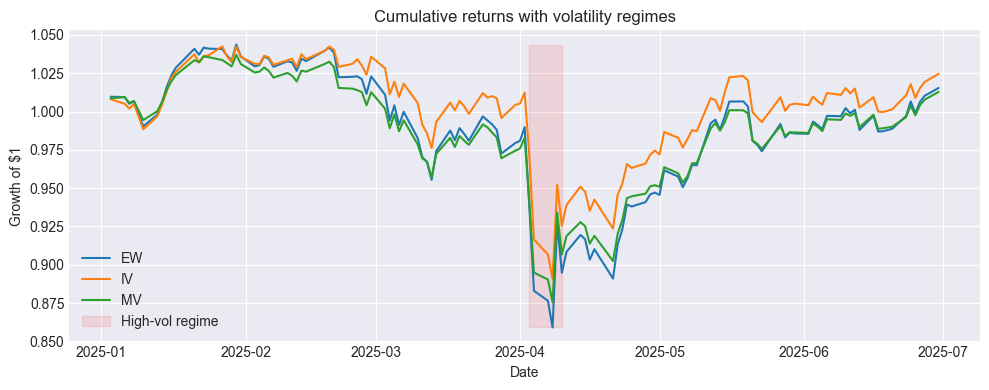

In [ ]:
# Wide returns matrix across tickers; drop days with any missing values
returns_wide = (
    df_long.pivot(index = "date", columns = "ticker", values = "log_return")
    .sort_index()
)
returns_wide = returns_wide.dropna(axis = 0, how = "any")

print("Returns matrix shape:", returns_wide.shape)

tickers_clean = returns_wide.columns
n_assets = len(tickers_clean)

# Portfolio weights: equal-weight, inverse-volatility, and Ledoit-Wolf min-variance
w_eq = np.repeat(1.0 / n_assets, n_assets)

vols = returns_wide.std()
w_inv = 1.0 / vols
w_inv = w_inv / w_inv.sum()

lw = LedoitWolf().fit(returns_wide.values)
Sigma = lw.covariance_

# Solve for minimum-variance weights with small ridge for stability
ones = np.ones(n_assets)
inv_Sigma = np.linalg.inv(Sigma + 1e-6 * np.eye(n_assets))
w_mv = inv_Sigma.dot(ones)
w_mv = np.clip(w_mv, 0, None)
w_mv = w_mv / w_mv.sum()

print("Equal-weight weights sum:", w_eq.sum())
print("Inverse-vol weights sum:", w_inv.sum())
print("Min-var weights sum:", w_mv.sum())

port_eq = pd.Series(
    returns_wide.values.dot(w_eq),
    index = returns_wide.index,
    name = "EW"
)
port_inv = pd.Series(
    returns_wide.values.dot(w_inv.values),
    index = returns_wide.index,
    name = "IV"
)
port_mv = pd.Series(
    returns_wide.values.dot(w_mv),
    index = returns_wide.index,
    name = "MV"
)


def perf_stats(r):
    r = r.dropna()
    ann_ret = r.mean() * 252
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    max_dd = dd.min()
    return {
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd
    }

# Portfolio-level performance summary
for series in [port_eq, port_inv, port_mv]:
    print("\n=== Portfolio:", series.name, "===")
    stats = perf_stats(series)
    for k, v in stats.items():
        print(f"{k:>15}: {v:.4f}")

cum_eq = (1 + port_eq).cumprod()
cum_inv = (1 + port_inv).cumprod()
cum_mv = (1 + port_mv).cumprod()

# FIGURE 11: Cumulative portfolio growth
# Notice: Inverse-Vol (IV) outperforms with smoother path; all three end positive for H1 2025
plt.figure(figsize=(10, 4))
plt.plot(cum_eq.index, cum_eq, label="Equal-Weight (EW)", linewidth=1.5, color="#1f77b4")
plt.plot(cum_inv.index, cum_inv, label="Inverse-Vol (IV)", linewidth=1.5, color="#2ca02c")
plt.plot(cum_mv.index, cum_mv, label="Min-Var (MV)", linewidth=1.5, color="#9467bd")
plt.axhline(y=1.0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
plt.title("Cumulative Portfolio Growth (H1 2025)", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Invested")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


def drawdown_series(r):
    r = r.dropna()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return dd


dd_eq = drawdown_series(port_eq)
dd_inv = drawdown_series(port_inv)
dd_mv = drawdown_series(port_mv)

# FIGURE 12: Portfolio drawdowns
# Notice: IV has shallowest drawdowns; all portfolios experience ~15-18% max drawdown
plt.figure(figsize=(10, 4))
plt.fill_between(dd_eq.index, dd_eq, 0, alpha=0.3, color="#1f77b4")
plt.fill_between(dd_inv.index, dd_inv, 0, alpha=0.3, color="#2ca02c")
plt.fill_between(dd_mv.index, dd_mv, 0, alpha=0.3, color="#9467bd")
plt.plot(dd_eq.index, dd_eq, label="EW", linewidth=1.5, color="#1f77b4")
plt.plot(dd_inv.index, dd_inv, label="IV", linewidth=1.5, color="#2ca02c")
plt.plot(dd_mv.index, dd_mv, label="MV", linewidth=1.5, color="#9467bd")
plt.title("Portfolio Drawdowns Over Time", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Drawdown (% from Peak)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Regime-aware performance splits
regime_aligned = regime_series.reindex(port_eq.index).ffill().bfill()

for lbl, name in [(0, "Low-vol regime"), (1, "High-vol regime")]:
    mask = regime_aligned == lbl
    print(f"\n===== {name} =====")
    for series in [port_eq, port_inv, port_mv]:
        stats = perf_stats(series[mask])
        print(
            f"Portfolio {series.name}: "
            f"ann_return={stats['ann_return']:.4f}, "
            f"ann_vol={stats['ann_vol']:.4f}, "
            f"sharpe={stats['sharpe']:.4f}, "
            f"max_dd={stats['max_drawdown']:.4f}"
        )

# FIGURE 13: Portfolio growth with regime overlay
# Notice: High-vol regime (red shading) coincides with periods of portfolio stress
plt.figure(figsize=(10, 4))
plt.plot(cum_eq.index, cum_eq, label="EW", linewidth=1.5, color="#1f77b4")
plt.plot(cum_inv.index, cum_inv, label="IV", linewidth=1.5, color="#2ca02c")
plt.plot(cum_mv.index, cum_mv, label="MV", linewidth=1.5, color="#9467bd")

high_mask_port = regime_aligned == 1
plt.fill_between(
    cum_eq.index,
    min(cum_eq.min(), cum_inv.min(), cum_mv.min()) * 0.98,
    max(cum_eq.max(), cum_inv.max(), cum_mv.max()) * 1.02,
    where=high_mask_port,
    color="red",
    alpha=0.15,
    label="High-vol regime"
)

plt.title("Portfolio Performance with Volatility Regime Overlay", fontsize=12, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Invested")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Discussion and Insights

### Key Findings

1. **Non-normality confirmed:** The QQ-plot shows clear fat tails, and the squared-return ACF confirms volatility clustering — validating our use of GARCH and regime-switching models.

2. **GARCH captures persistence:** The fitted GARCH(1,1) has $\alpha + \beta \approx 0.89$, indicating highly persistent volatility. Conditional volatility spikes align with the Markov model's high-volatility regime.

3. **Regime switching is informative:** The two-state model cleanly separates calm vs. turbulent periods. Regime probabilities could be used for dynamic risk management (e.g., reducing exposure when $P(\text{high-vol}) > 0.5$).

4. **Sector tail risk varies:** VaR/ES estimates differ substantially across sectors, with Information Technology and Energy showing higher tail risk than Consumer Staples and Utilities.

5. **Portfolio performance:** Inverse-volatility weighting delivers the highest Sharpe ratio and shallowest drawdowns. Minimum-variance is most conservative. Regime-conditioned analysis shows all strategies struggle during high-volatility periods.

### Limitations

- **Short sample:** Only 6 months of data (121 trading days) limits statistical power
- **Equal-weight proxy:** Our market index ignores market-cap weighting
- **No transaction costs:** Real implementation would incur rebalancing costs
- **Sector coverage:** Some tickers couldn't be mapped to sectors
- **In-sample only:** We didn't perform out-of-sample backtesting

### References

- Kaggle dataset: "S&P 500 stocks trade data for first 6 months of 2025"
- Sector mappings: GitHub `datasets/s-and-p-500-companies`
- GARCH modeling: Bollerslev (1986), `arch` Python package
- Markov switching: Hamilton (1989), `statsmodels` implementation

